## Titanic Snake
  
Esse caderno tem o objetivo de construir uma aplicação em python para o titanic do Kaggle.  
Para completar essa task é preciso que o usuário faça uma predição de se um passageiro do _Titanic_ sobreviveu com base em um dataset disponibilizado no arquivo train.csv e deve ser dado um resultado para esses fatores com o arquivo test.csv.  
O Formato de submissão do arquivo deve ser o de um csv com duas columns com os cabeçalhos _PassengerId_ e _suvived_. Esse resultado será avaliado pela Kaggle e dará o resultado do quão boa é sua solução.

**Obs**: A recomendação da Kaggle é o uso de binary classification

In [1]:
## Import libs
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

% matplotlib inline

In [2]:
## Load datasets
train_dataset = pandas.read_csv("train.csv")
test_dataset = pandas.read_csv("test.csv")

## Remove as tables desnecessárias. OBS: O PassengerId não importa nos dados de treinamento mas no output sim
train_dataset = train_dataset.drop(columns=["Name", "Ticket", "Cabin"]) # TODO: Reavaliar a importância de SibSp, parch
test_dataset = test_dataset.drop(columns=["Name", "Ticket", "Cabin"])

In [3]:
## Compila uma inferência para as idades
train_dataset["Age"] = train_dataset["Age"].apply(func=lambda x: 5*math.floor(x/5.0) if not math.isnan(x) else x)
train_dataset["Fare"] = train_dataset["Fare"].apply(func=lambda x: 5*math.floor(x/5.0) if not math.isnan(x) else x)

test_dataset["Age"] = test_dataset["Age"].apply(func=lambda x: 5*math.floor(x/5.0) if not math.isnan(x) else x)
test_dataset["Fare"] = test_dataset["Fare"].apply(func=lambda x: 5*math.floor(x/5.0) if not math.isnan(x) else x)

In [4]:
## Remove every single NaN and puts 0 because it will ignore the data input in the inference model
train_dataset["Embarked"] = train_dataset["Embarked"].fillna("C") # trata o caso das strings da classe de embarque
test_dataset["Embarked"] = test_dataset["Embarked"].fillna("C") # trata o caso das strings da classe de embarque
train_dataset = train_dataset.fillna(-1)
test_dataset = test_dataset.fillna(-1)

In [5]:
## Define como categorizar uma column
def cathegoryList(lst):
    st = sorted(set(lst))
    cathegories = dict((b,a) for a,b in enumerate(st))
    return cathegories

def cathegorize(lst):
    cathegories = cathegoryList(lst)
    lst = [cathegories[a] for a in lst]
    return lst

animals = cathegorize(["cat", "dog", "dog", "perl", "omastar", "cat", "dog"])
print(animals)

[0, 1, 1, 3, 2, 0, 1]


In [6]:
train = train_dataset.sample(frac=0.9)
test = train_dataset.drop(index=train.index)

In [7]:
def normalize_dict(d):
    minval = min(d.items(), key=lambda x: x[1])[1]
    maxval = max(d.items(), key=lambda x: x[1])[1]
    d = {k: (v-minval)/(maxval-minval) + 1 for k, v in d.items()}
    return d

In [8]:
## Probabilidade de sobreviver por sexo
df = train["Sex"].groupby(train["Survived"]).value_counts().unstack()
male_rate = df["male"][1]/df["male"].sum()
female_rate = df["female"][1]/df["female"].sum()
sex_rate = {
    "male": male_rate,
    "female": female_rate
}

normalize_dict(sex_rate)

{'male': 1.0, 'female': 2.0}

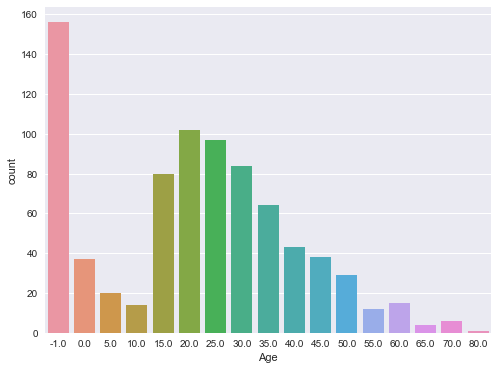

In [9]:
plt.figure(figsize=(8,6))
plt.style.use('seaborn')
sns.countplot(data=train,x='Age')

In [10]:
## Probabilidade de sobreviver para cada idade
df = train["Age"].groupby(train["Survived"]).value_counts().unstack()
ages_rate = dict()
for age in df:
    ages_rate[age] = df[age][1]/df[age].sum()
    if math.isnan(ages_rate[age]): ages_rate[age] = 0

ages_rate = normalize_dict(ages_rate)

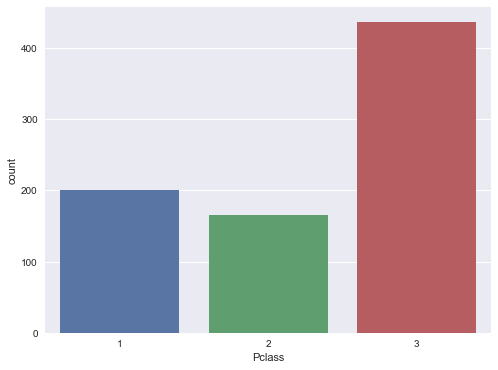

In [11]:
plt.figure(figsize=(8,6))
plt.style.use('seaborn')
sns.countplot(data=train,x='Pclass')

In [12]:
## Probabilidade de sobreviver pela classe que o passageiro está
df = train["Pclass"].groupby(train["Survived"]).value_counts().unstack()
pclass_rate = dict()
for pclass in df:
    pclass_rate[pclass] = df[pclass][1]/df[pclass].sum()
    if math.isnan(pclass_rate[pclass]): pclass_rate[pclass] = 0

pclass_rate = normalize_dict(pclass_rate)

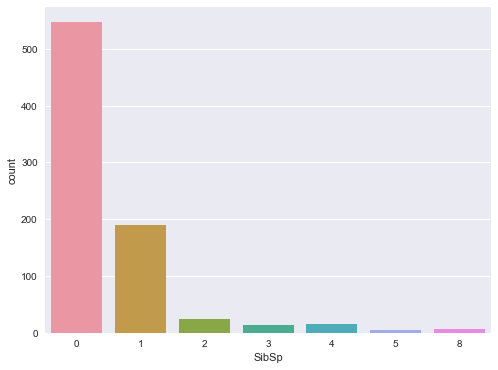

In [13]:
plt.figure(figsize=(8,6))
plt.style.use('seaborn')
sns.countplot(data=train,x='SibSp')

In [14]:
## Probabilidade de sobreviver pela classe que o passageiro está
df = train["SibSp"].groupby(train["Survived"]).value_counts().unstack()
sibsp_rate = dict()
for sibsp in df:
    sibsp_rate[sibsp] = df[sibsp][1]/df[sibsp].sum()
    if math.isnan(sibsp_rate[sibsp]): sibsp_rate[sibsp] = 0

sibsp_rate = normalize_dict(sibsp_rate)

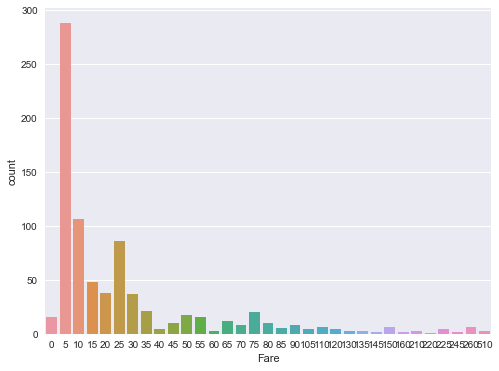

In [15]:
plt.figure(figsize=(8,6))
plt.style.use('seaborn')
sns.countplot(data=train,x='Fare')

In [16]:
## Probabilidade de sobreviver pela classe que o passageiro está
df = train["Fare"].groupby(train["Survived"]).value_counts().unstack()
fare_rate = dict()
for fare in df:
    fare_rate[fare] = df[fare][1]/df[fare].sum()
    if math.isnan(fare_rate[fare]): fare_rate[fare] = 0

fare_rate = normalize_dict(fare_rate)

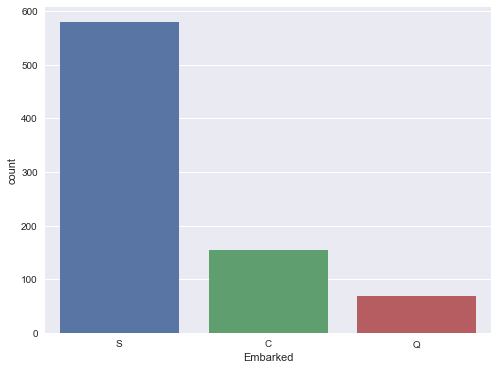

In [17]:
plt.figure(figsize=(8,6))
plt.style.use('seaborn')
sns.countplot(data=train,x='Embarked')

In [18]:
df = train["Embarked"].groupby(train["Survived"]).value_counts().unstack()
embarked_rate = dict()
for embarked in df:
    embarked_rate[embarked] = df[embarked][1]/df[embarked].sum()
    if math.isnan(embarked_rate[embarked]): embarked_rate[embarked] = "C"

embarked_rate = normalize_dict(embarked_rate)

In [19]:
def computeAge(a):
    age = 5*math.floor(a/5)
    if age < 0:
        return -1
    return 5*math.floor(a/5)

prob = []
## Itera sobre as linhas do dataset de treino para verificar a eficiência do algorítimo
for index, row in train.iterrows():
    prob += [(ages_rate[computeAge(row["Age"])] * pclass_rate[row["Pclass"]] * sex_rate[row["Sex"]] 
            * sibsp_rate[row["SibSp"]] * fare_rate[computeAge(row["Fare"])] * embarked_rate[row["Embarked"]])]
    
prob = [int((a - min(prob))/(max(prob) - min(prob)) >= 0.2) for a in prob]
ct = 0
accept_rate = 0
for index, row in train.iterrows():
    if prob[ct] == row["Survived"]:
        accept_rate += 1
    ct += 1

accept_rate /= ct
print(accept_rate)

0.8017456359102244


In [20]:
## Itera sobre as linhas do dataset de test para verificar a eficiência do algorítimo
for index, row in test.iterrows():
    try:
        prob += [(ages_rate[computeAge(row["Age"])] * pclass_rate[row["Pclass"]] * sex_rate[row["Sex"]] 
            * sibsp_rate[row["SibSp"]] * fare_rate[computeAge(row["Fare"])] * embarked_rate[row["Embarked"]])]
    except:
        prob += [None]

minval = min([a for a in prob if a is not None])
maxval = max([a for a in prob if a is not None])
prob = [a if a is not None else 1 for a in prob]
prob = [int((a - minval)/(maxval - minval) >= 0.2) for a in prob]
ct = 0
accept_rate = 0
for index, row in train.iterrows():
    if prob[ct] == row["Survived"]:
        accept_rate += 1
    ct += 1
    
accept_rate /= ct
print(accept_rate)

0.6109725685785536


In [21]:
prob = []
for index, row in test_dataset.iterrows():
    try:
        prob += [(ages_rate[computeAge(row["Age"])] * pclass_rate[row["Pclass"]] * sex_rate[row["Sex"]] 
            * sibsp_rate[row["SibSp"]] * fare_rate[computeAge(row["Fare"])] * embarked_rate[row["Embarked"]])]
    except:
        prob += [None]

minval = min([a for a in prob if a is not None])
maxval = max([a for a in prob if a is not None])
prob = [a if a is not None else 1 for a in prob]
prob = [int((a - minval)/(maxval - minval) >= 0.2) for a in prob]

print(prob)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 

In [22]:
output = test_dataset["PassengerId"].copy()
output = output.to_frame()

print(output.shape, len(prob))
# print(output)
output = output.assign(Survived=prob)

filename = "titanic_statistics_survivors.csv"
output.to_csv(filename, sep=',', encoding='utf-8', header=True, index=False)

(418, 1) 418
